In [1]:
%matplotlib inline

import subprocess 
from PyAstronomy import pyasl
import numpy as np
import pandas as pd
import math

# -----------------------------------------------------

import ObsPlanets_Processing as OPP
import star_pop as st_pop
import MESA_processing
import hz
from star_pop import generate_star_population, plot_distributions,quantize_population
from star_pop import SamplerContainer,save_samplers,load_samplers
from MESA_processing import match_to_mesa_sims,match_to_mesa_sims_fast


# -----------------------------------------------------

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import scipy.optimize as optimize
import numpy as np
import scipy as sp
from astropy import constants as const
from matplotlib.pyplot import cm
import matplotlib.colors as colors
from pylab import rcParams
import math
import random

from scipy.stats import kde
from matplotlib.collections import PathCollection

import mesa_reader as mr
import scipy as sp
import matplotlib as mpl
import glob
import os
from pylab import rcParams
import inspect
from pathlib import Path  # Import the Path class

from astropy import constants as const

plt.rcParams.update({'font.size': 20})
plt.rcParams['figure.figsize'] = 10, 10

class COLOR:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# print(COLOR.BOLD + 'Hello, World!' + COLOR.END) # ------------- example

def get_var_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]


## Population

In [3]:
# --- Workflow Configuration ---
# Options: 'generate_on_the_fly', 'create_and_save_samplers', 'load_samplers_and_generate'
MODE = 'create_and_save_samplers'  

SAVE_TO_CSV = True
SEED = random.randint(0,1e9)  # Set to None for a random run

# --- Simulation Configuration ---
NUM_STARS = 1000000
DISK_TYPE = "thin"
GALAXY_SHAPE = "spiral"    # "elliptical" or "spiral"
MZAMS_MIN, MZAMS_MAX = 0.11, 220.0
T_MAX_AGE = 13.6
FEH_MIN = -3.0
FEH_MAX = 0.5

SAMPLER_RESOLUTION = 1000000 # Controls accuracy vs. setup time for samplers


OUTPUT_DIR = f"{GALAXY_SHAPE}_{DISK_TYPE}_disk_run"

SAMPLER_FILE = os.path.join("samplers",f"res{SAMPLER_RESOLUTION}_{MZAMS_MIN}_{MZAMS_MAX}_samplers.pkl")
POP_DIR = os.path.join(OUTPUT_DIR,"population")

# --- Spiral Arm Configuration ---
SFR_PROBABILITY_BY_ARM = [
    {'name': 'Scutum-Centaurus', 'min_probability_pct': 35, 'max_probability_pct': 45},
    {'name': 'Perseus', 'min_probability_pct': 25, 'max_probability_pct': 35},
    {'name': 'Local (Orion) Arm', 'min_probability_pct': 10, 'max_probability_pct': 15},
    {'name': 'Sagittarius', 'min_probability_pct': 5, 'max_probability_pct': 10},
    {'name': 'Norma', 'min_probability_pct': 5, 'max_probability_pct': 10}
]
# Defines the physical shape of the logarithmic spiral arms.
# a_kpc: Radius at theta=0. b: related to pitch angle. theta0_rad: rotation offset.
ARM_PARAMS = [
    {'name': 'Scutum-Centaurus', 'a_kpc': 3.5, 'b': 1 / math.tan(math.radians(12)), 'theta0_rad': math.radians(20)},
    {'name': 'Perseus', 'a_kpc': 4.9, 'b': 1 / math.tan(math.radians(12)), 'theta0_rad': math.radians(150)},
    {'name': 'Local (Orion) Arm', 'a_kpc': 4.0, 'b': 1 / math.tan(math.radians(10)), 'theta0_rad': math.radians(100)},
    {'name': 'Sagittarius', 'a_kpc': 4.0, 'b': 1 / math.tan(math.radians(12)), 'theta0_rad': math.radians(280)},
    {'name': 'Norma', 'a_kpc': 3.0, 'b': 1 / math.tan(math.radians(12)), 'theta0_rad': math.radians(200)}
]
ANGULAR_SCATTER_DEG = 2.5 # Scatter around the centerline of the arm


# --- Seed the random number generators for reproducibility ---
if SEED is not None:
    np.random.seed(SEED)
    random.seed(SEED)

# --- Main Workflow Logic ---
samplers = None
if MODE == 'create_and_save_samplers':
    samplers = SamplerContainer(MZAMS_MIN, MZAMS_MAX, resolution=SAMPLER_RESOLUTION)
    save_samplers(samplers, SAMPLER_FILE)

else: # For 'generate_on_the_fly' or 'load_samplers_and_generate'
    if MODE == 'load_samplers_and_generate':
        if not os.path.exists(SAMPLER_FILE):
            raise FileNotFoundError(f"Sampler file not found: {SAMPLER_FILE}. Please run in 'create_and_save_samplers' mode first.")
        samplers = load_samplers(SAMPLER_FILE)
    else: # generate_on_the_fly
        samplers = SamplerContainer(DISK_TYPE, MZAMS_MIN, MZAMS_MAX, resolution=SAMPLER_RESOLUTION)


Generating 1000000 stars for the thin model in a spiral galaxy...
Generation complete.
Original data saved to spiral_thin_disk_run/population/star_population_thin_1000000.csv

Here are the first 5 stars from the simulation:
      Mzams  Lookback time [Gyr]  Age [Gyr]      Fe/H  Radial Distance [kpc]  \
0  0.319908            10.554760   3.045240 -0.129822               8.575955   
1  0.202890            10.873659   2.726341 -0.646030               3.409386   
2  0.292901            12.889103   0.710897 -0.635205               3.733546   
3  1.725101            12.371645   1.228355 -0.961164               2.335232   
4  0.528151             9.432886   4.167114 -0.748923               2.787060   

   Vertical Distance [kpc]      Arm Position  alpha_angle_deg  random_seed  \
0                 0.024617           Perseus       154.687344    974069288   
1                 1.275936           Perseus       146.464080    974069288   
2                 1.826608           Perseus       147.588029

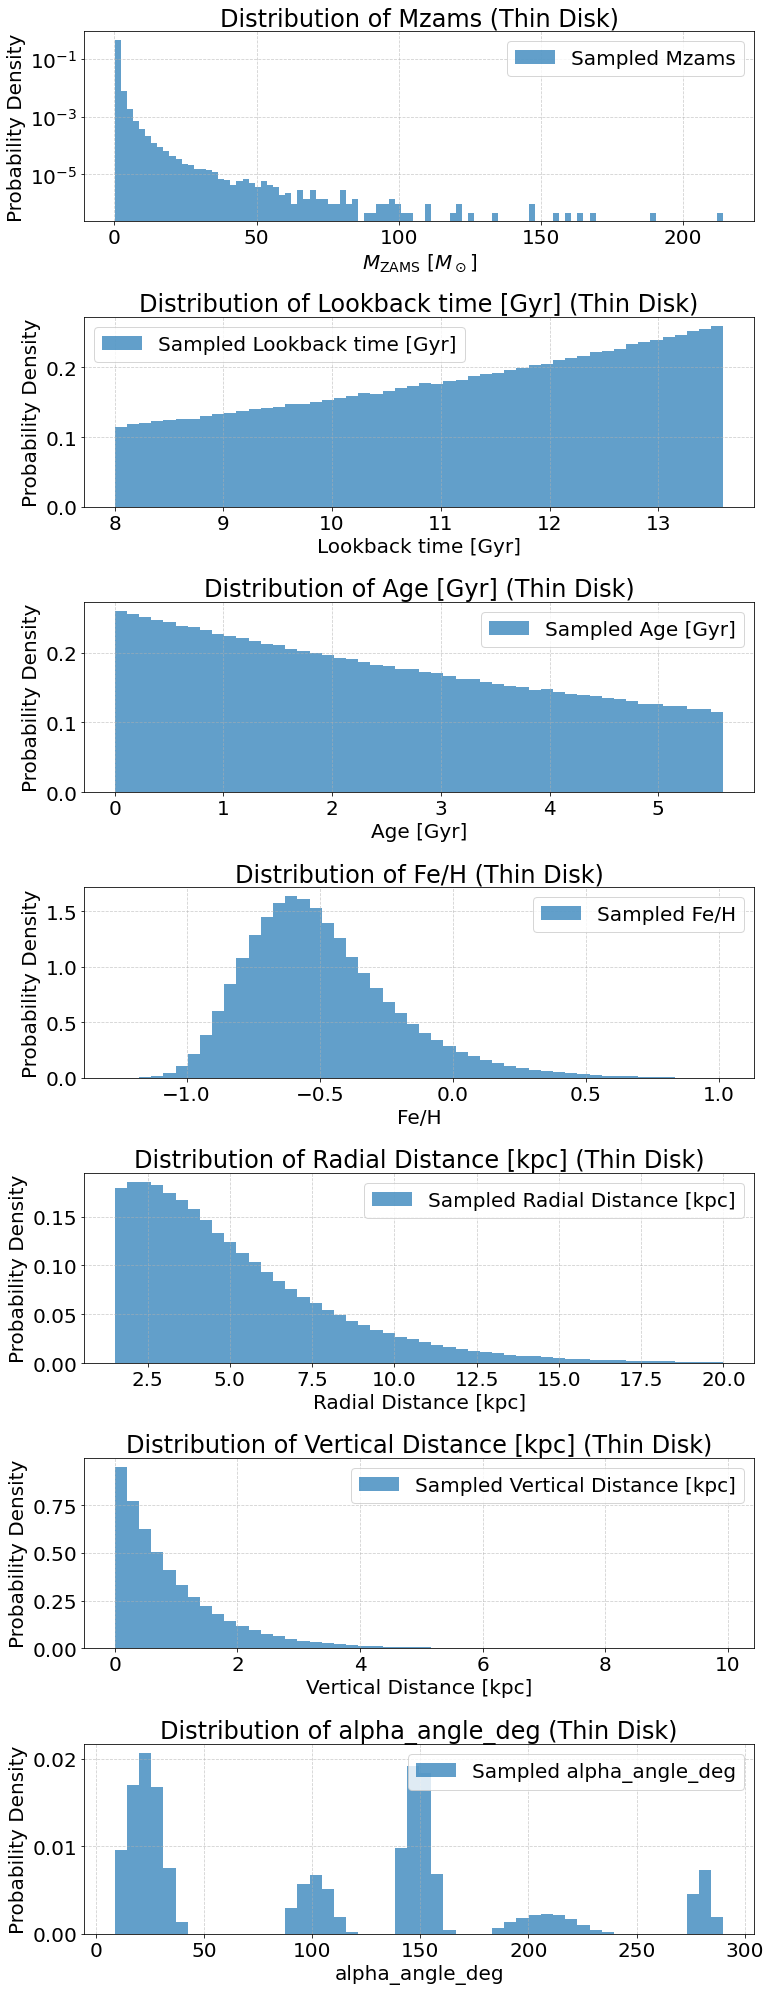

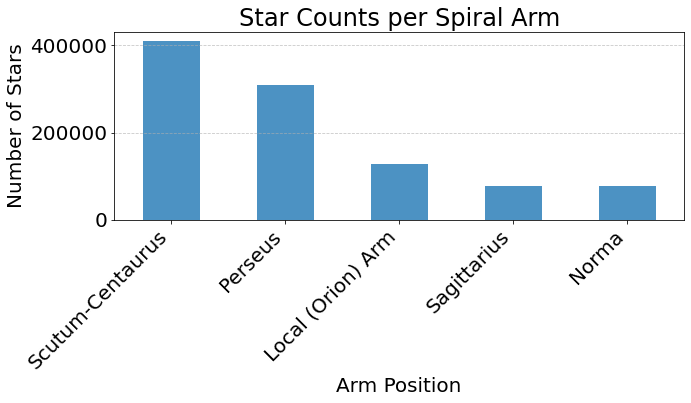

In [8]:
# 1. Generate the stellar population
population_df = generate_star_population(
    num_stars=NUM_STARS,
    samplers=samplers,
    disk_type=DISK_TYPE,
    galaxy_shape=GALAXY_SHAPE,
    arm_params_list=ARM_PARAMS,
    sfr_probs_list=SFR_PROBABILITY_BY_ARM,
    angular_scatter_deg=ANGULAR_SCATTER_DEG,
    seed=SEED,
    FeH_min=FEH_MIN,  # Pass the new limits
    FeH_max=FEH_MAX   # Pass the new limits
    )

# 2. Optionally save the original data
if SAVE_TO_CSV:
    if not os.path.exists(POP_DIR):
        os.makedirs(POP_DIR)
    filepath = os.path.join(POP_DIR, f"star_population_{DISK_TYPE}_{NUM_STARS}.csv")
    population_df.to_csv(filepath, index=False)
    print(f"Original data saved to {filepath}")

# You can now work with the data directly! For example:
print("\nHere are the first 5 stars from the simulation:")
print(population_df.head())

print("\nHere are some basic statistics about the population:")
print(population_df.describe())


# 3. Call the plotting function to visualize the results
plot_distributions(population_df, disk_type=DISK_TYPE)

### Take the datafile

In [3]:
population_df = pd.read_csv(f"{OUTPUT_DIR}/population/star_population_{DISK_TYPE}_{NUM_STARS}.csv",
                            low_memory=False)

### Galactic position

/home/aromagnolo/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:137: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


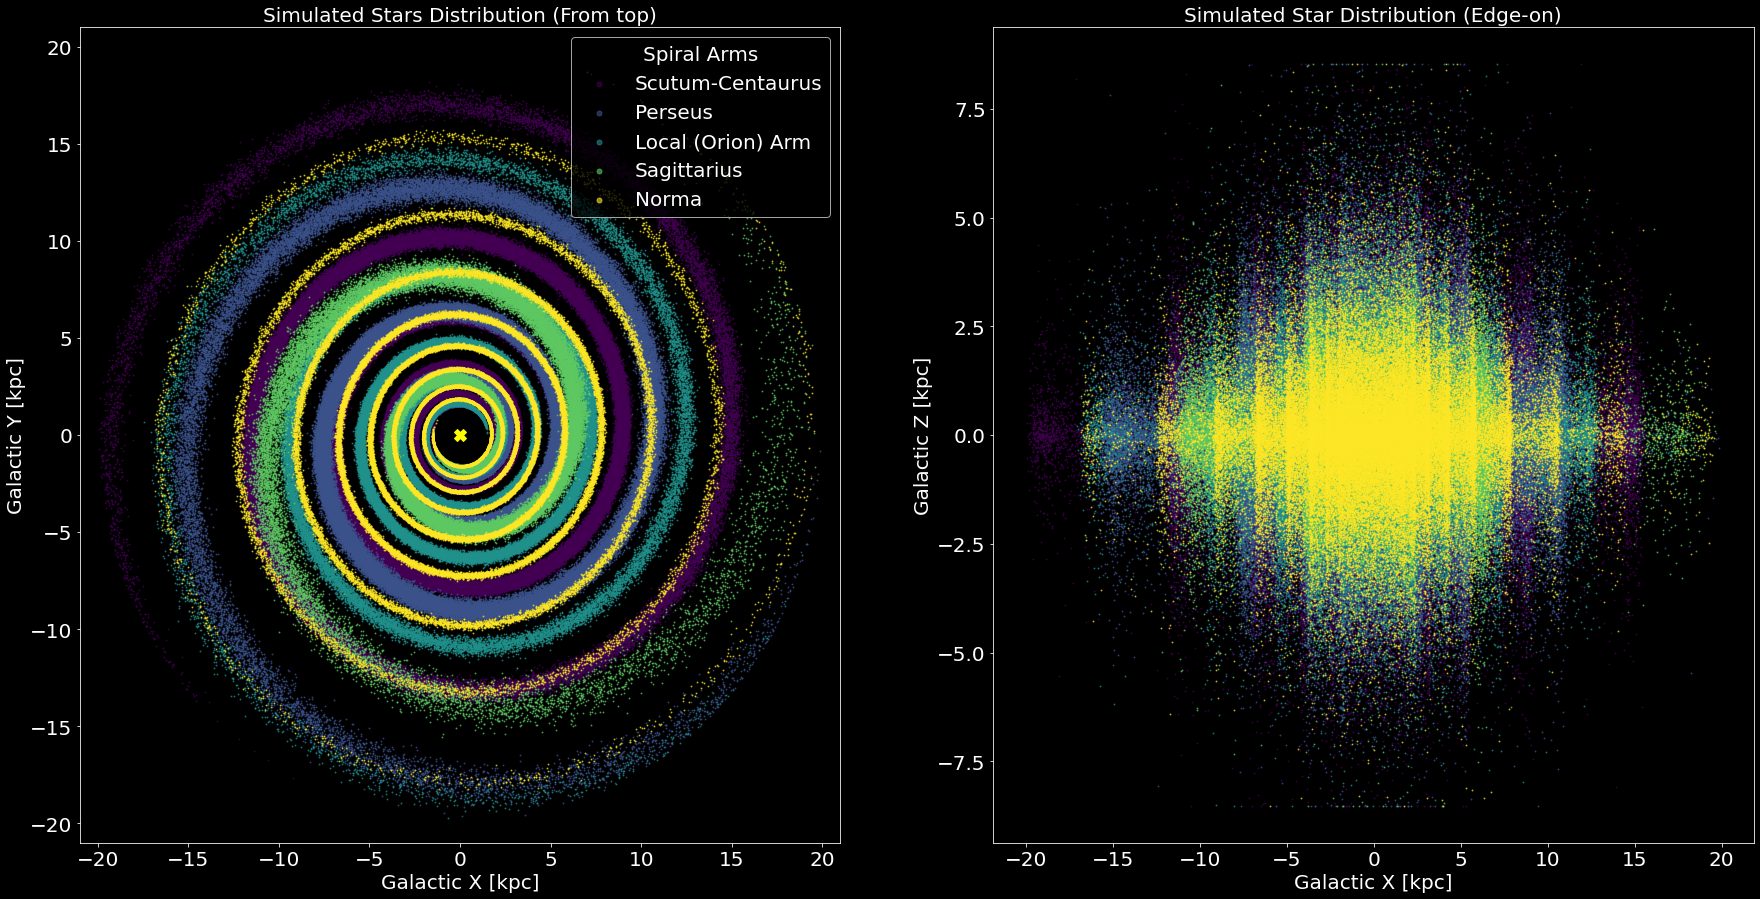

In [5]:
plt.style.use('dark_background')
fig, ax = plt.subplots(1,2,figsize=(30, 15))



if GALAXY_SHAPE == "spiral":
    
    arm_names = [arm['name'] for arm in ARM_PARAMS]
    colors = plt.cm.viridis(np.linspace(0, 1, len(arm_names)))
    color_map = {name: color for name, color in zip(arm_names, colors)}
    
    for arm_name in arm_names:
        arm_stars = [star for ind, star in population_df.iterrows() if star['Arm Position'] == arm_name]
            
        x_coords = [star['Radial Distance [kpc]'] * np.cos(star['alpha_angle_deg']) for star in arm_stars]
        y_coords = [star['Radial Distance [kpc]'] * np.sin(star['alpha_angle_deg']) for star in arm_stars]
        z_coords = [star['Vertical Distance [kpc]'] * random.choices([-1,1])[0] for star in arm_stars]
        ax[0].scatter(x_coords, y_coords, color=color_map[arm_name], s=1, label=arm_name, alpha=0.6)
        ax[1].scatter(x_coords, z_coords, color=color_map[arm_name], s=1, label=arm_name, alpha=0.6)
        
    ax[0].legend(title='Spiral Arms', location='upper right' markerscale=5)
    ax[0].plot(0, 0, 'X', color='yellow', markersize=12, label='Galactic Center')
        
        
        
else:
    x_coords = population_df['Radial Distance [kpc]'] * np.cos(population_df['alpha_angle_deg'])
    y_coords = population_df['Radial Distance [kpc]'] * np.sin(population_df['alpha_angle_deg'])
    z_coords = [star * random.choices([-1,1])[0] for star in population_df['Vertical Distance [kpc]']]
    ax[0].scatter(x_coords, y_coords, s=1, alpha=0.6,c=population_df['Radial Distance [kpc]'], cmap='viridis')
    ax[1].scatter(x_coords, z_coords, s=1, alpha=0.6,c=population_df['Radial Distance [kpc]'], cmap='viridis')
    

ax[0].set_title('Simulated Stars Distribution (From top)', fontsize=20)
ax[1].set_title('Simulated Star Distribution (Edge-on)', fontsize=20)
ax[0].set_xlabel('Galactic X [kpc]')
ax[1].set_xlabel('Galactic X [kpc]')
ax[0].set_ylabel('Galactic Y [kpc]')
ax[1].set_ylabel('Galactic Z [kpc]')
# ax[0].set_aspect('equal', adjustable='box')
# ax[1].set_aspect('equal', adjustable='box')
# ax[0].grid(True, alpha=0.2)
    
ax[0].set_xlim(-21, 21)
ax[0].set_ylim(-21, 21)
    
plt.show()

### Quantization

Quantizing mass and metallicity using vectorized NumPy...
Quantization complete.


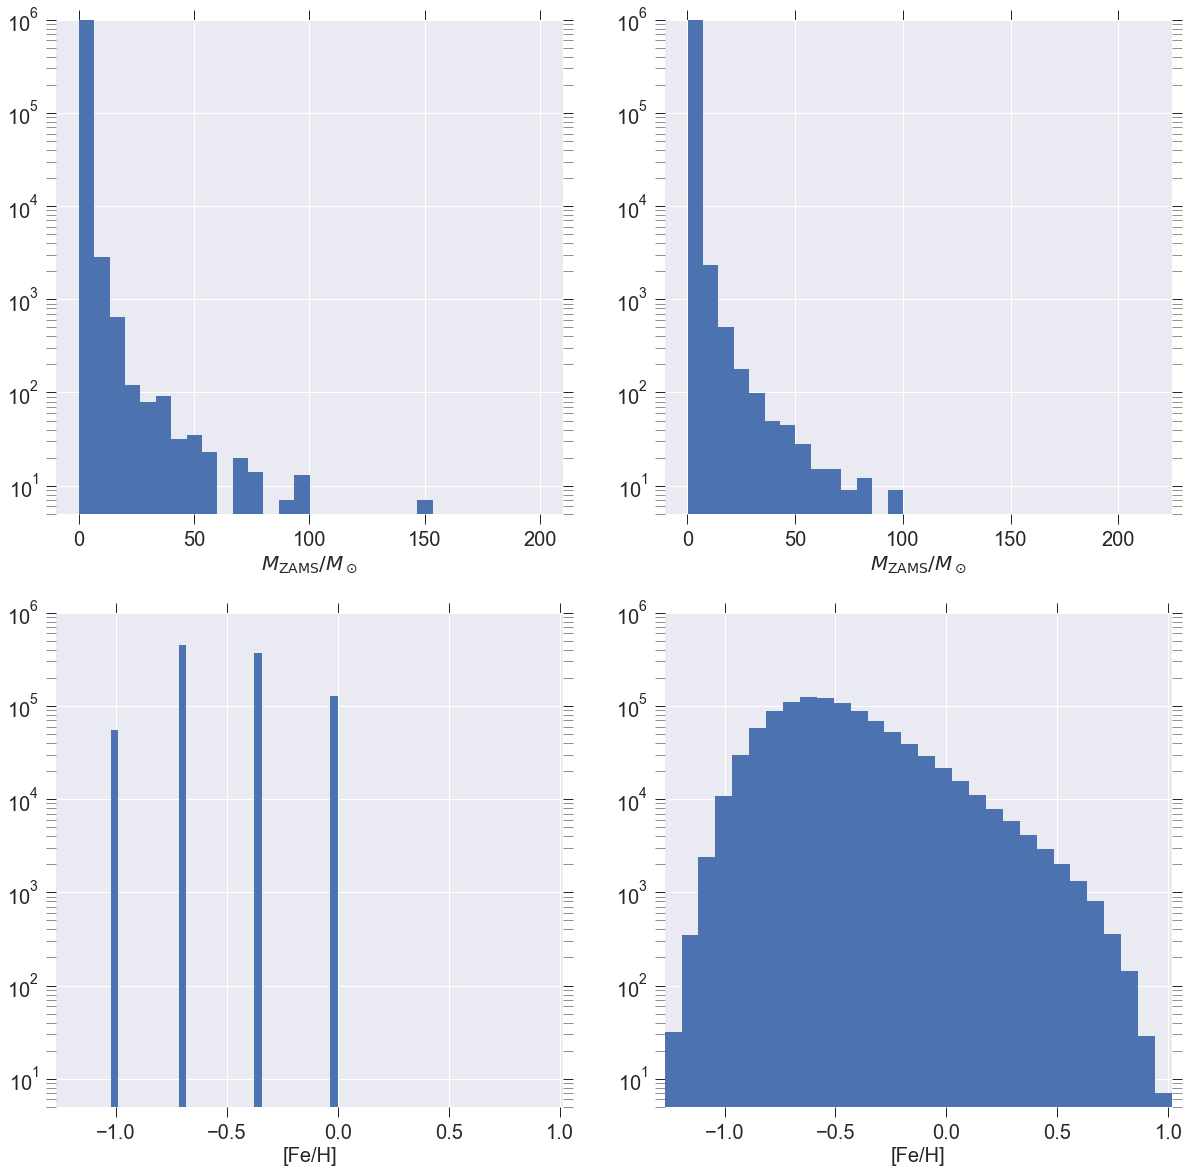

In [4]:
# --- Model Grids for Quantization ---

# This grid defines the available stellar masses for the model.
# The quantization function will snap generated masses to the nearest value in this list.
stellar_mass_grid = np.array([
    0.11, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275, 0.3, 0.325, 0.35, 
    0.375, 0.4, 0.425, 0.45, 0.475, 0.5, 0.525, 0.55, 0.575, 0.6, 0.625, 
    0.65, 0.675, 0.7, 0.725, 0.75, 0.775, 0.8, 0.825, 0.85, 0.875, 0.9, 
    0.925, 0.95, 0.975, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 
    3.5, 3.75, 4, 4.25, 4.5, 4.75, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 
    16, 17, 18, 19, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 
    150, 200, 250
])

# This grid defines the available metallicities ([Fe/H]) for the model.
metallicity_grid = np.log10([0.1, 0.2, 0.45, 1])/0.977     # Bertelli et al. 1994a

q_df = quantize_population(population_df, stellar_mass_grid, metallicity_grid,in_place=False)
# in_place = True/False  --- Faster, but overrides population_df (histograms cannot be used)/Slower, but histog.

# 1. Construct the full file path
filepath_q = os.path.join(OUTPUT_DIR, "quantized", f"star_population_{DISK_TYPE}_{NUM_STARS}_q.csv")

# 2. Get the directory part of the path
output_directory = os.path.dirname(filepath_q)

# 3. Create the directory if it doesn't exist
Path(output_directory).mkdir(parents=True, exist_ok=True)

# 4. Now, save the file with confidence
q_df.to_csv(filepath_q, index=False) 


# 5. Plot

fig, ax = plt.subplots(2,2,figsize=(20,20))

ax[0,0].hist(q_df["Mzams"],bins=30)
ax[0,1].hist(population_df["Mzams"],bins=30)

ax[1,0].hist(q_df["Fe/H"],bins=30)
ax[1,1].hist(population_df["Fe/H"],bins=30)

for axs in ax:
    for xs in axs:
        xs.set_yscale('log')
        xs.tick_params(labelsize=20,axis='both', which='both',top=True,right=True,length=10)
        if xs == ax[0,0] or xs == ax [0,1]:
            xs.set_ylim(5,len(q_df["Mzams"]))
            xs.set_xlabel("$M_\mathrm{ZAMS}/M_\odot$",fontsize=20)
        else:
            xs.set_ylim(5,len(q_df["Fe/H"]))
            xs.set_xlim(np.min([np.min(q_df["Fe/H"]),np.min(population_df["Fe/H"])]),
                        np.max([np.max(q_df["Fe/H"]),np.max(population_df["Fe/H"])]))
            xs.set_xlabel("[Fe/H]",fontsize=20)
    

plt.show()

### Combine with MESA tracks

In [6]:
direc = "/MESA Simulations"

mesa_cols_to_extract = ["star_age","star_mass","log_R","log_Teff","log_L","log_Rzams","log_Lzams",
                        "log_Teffzams","log_RMAX","RMAX_logL","RMAX_logTeff","max_age"]


df_mesa = match_to_mesa_sims_fast(q_df, direc, mesa_cols_to_extract)


Matching population to MESA simulations (vectorized)...
Z = 0.1Zsun; Mzams = 0.11
Z = 0.2Zsun; Mzams = 0.11
Z = 0.45Zsun; Mzams = 0.11
Z = 1Zsun; Mzams = 0.11
Z = 0.1Zsun; Mzams = 0.125
Z = 0.2Zsun; Mzams = 0.125
Z = 0.45Zsun; Mzams = 0.125
Z = 1Zsun; Mzams = 0.125
Z = 0.1Zsun; Mzams = 0.15
Z = 0.2Zsun; Mzams = 0.15
Z = 0.45Zsun; Mzams = 0.15
Z = 1Zsun; Mzams = 0.15
Z = 0.1Zsun; Mzams = 0.175
Z = 0.2Zsun; Mzams = 0.175
Z = 0.45Zsun; Mzams = 0.175
Z = 1Zsun; Mzams = 0.175
Z = 0.1Zsun; Mzams = 0.2
Z = 0.2Zsun; Mzams = 0.2
Z = 0.45Zsun; Mzams = 0.2
Z = 1Zsun; Mzams = 0.2
Z = 0.1Zsun; Mzams = 0.225
Z = 0.2Zsun; Mzams = 0.225
Z = 0.45Zsun; Mzams = 0.225
Z = 1Zsun; Mzams = 0.225
Z = 0.1Zsun; Mzams = 0.25
Z = 0.2Zsun; Mzams = 0.25
Z = 0.45Zsun; Mzams = 0.25
Z = 1Zsun; Mzams = 0.25
Z = 0.1Zsun; Mzams = 0.275
Z = 0.2Zsun; Mzams = 0.275
Z = 0.45Zsun; Mzams = 0.275
Z = 1Zsun; Mzams = 0.275
Z = 0.1Zsun; Mzams = 0.3
Z = 0.2Zsun; Mzams = 0.3
Z = 0.45Zsun; Mzams = 0.3
Z = 1Zsun; Mzams = 0.3
Z = 0.1Z

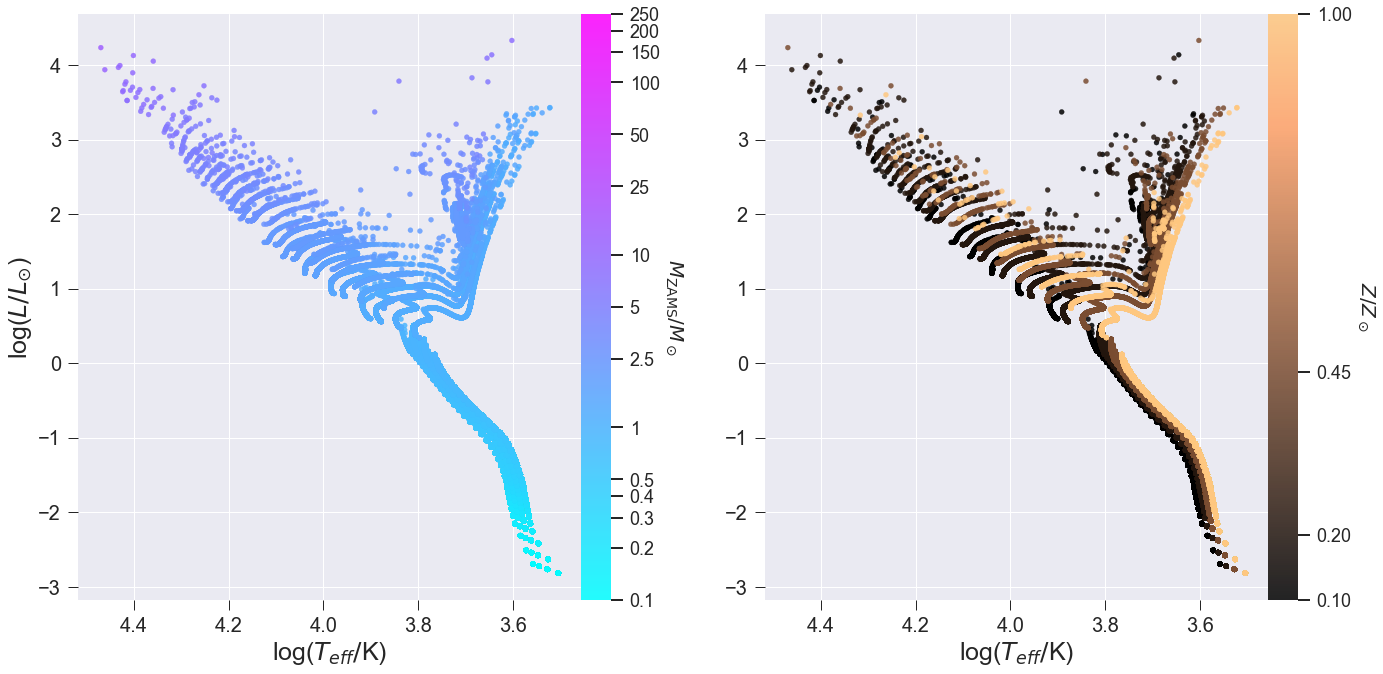

In [7]:
import matplotlib.ticker as ticker
import matplotlib.colors as colors

stellar_mass_grid = np.array([
    0.11, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275, 0.3, 0.325, 0.35, 
    0.375, 0.4, 0.425, 0.45, 0.475, 0.5, 0.525, 0.55, 0.575, 0.6, 0.625, 
    0.65, 0.675, 0.7, 0.725, 0.75, 0.775, 0.8, 0.825, 0.85, 0.875, 0.9, 
    0.925, 0.95, 0.975, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 
    3.5, 3.75, 4, 4.25, 4.5, 4.75, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 
    16, 17, 18, 19, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 
    150, 200, 250
])

# This grid holds the [Fe/H] values for the models
metallicity_grid = np.array([0.1, 0.2, 0.45, 1])

# --- Generate the custom ticks based on your grids ---

# For the mass colorbar: 
mass_ticks = [0.1,0.2,0.3,0.4,0.5,1.0,2.5,5,10,25,50,100,150,200,250]

# For the metallicity colorbar: these are the Z/Zsun values
# corresponding to the [Fe/H] grid values.
metal_ticks = metallicity_grid


# --- Plotting ---

plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Use the full grid range for normalization to ensure colors are consistent
# and all specified ticks are correctly placed within the colorbar's range.
cmap_M = plt.get_cmap('cool')
cmap_Z = plt.get_cmap('copper')
norm_M = colors.LogNorm(0.1, stellar_mass_grid.max())
norm_Z = plt.Normalize(metal_ticks.min(), metal_ticks.max())

# --- Scatter Plot 1 (Colored by Mass) ---
mzams_scatter = ax[0].scatter(df_mesa["log_Teff"], df_mesa["log_L"],
                              c=df_mesa["Mzams"], cmap=cmap_M, norm=norm_M,
                              marker='o', alpha=0.85, s=25)

# --- Scatter Plot 2 (Colored by Metallicity) ---
metal_scatter = ax[1].scatter(df_mesa["log_Teff"], df_mesa["log_L"],
                               c=10**(df_mesa["Fe/H"]*0.977), cmap=cmap_Z, norm=norm_Z,
                               marker='o', alpha=0.85, s=25)

# --- Create and Customize Colorbar 1 (Mass) ---
cbar0 = plt.colorbar(mzams_scatter, ax=ax[0], ticks=mass_ticks, pad=0.0)
cbar0.set_label(r'$M_\mathrm{ZAMS} / M_\odot$', rotation=270, labelpad=25, fontsize=20)
cbar0.ax.tick_params(labelsize=18, size=12, width=2)
# Use general-purpose formatting to avoid unnecessary trailing zeros
cbar0.ax.set_yticklabels([f'{tick:g}' for tick in mass_ticks])

# --- Create and Customize Colorbar 2 (Metallicity) ---
cbar1 = plt.colorbar(metal_scatter, ax=ax[1], ticks=metal_ticks, pad=0.0)
cbar1.set_label(r'$Z / Z_\odot$', rotation=270, labelpad=25, fontsize=20)
cbar1.ax.tick_params(labelsize=18, size=12, width=2)
# Format the metallicity ticks to 2 decimal places for better readability
cbar1.ax.set_yticklabels([f'{tick:.2f}' for tick in metal_ticks])

# --- Customize Axis and Ticks for subplots ---
for axs in ax:
    axs.set_xlabel('log($T_{eff}/$K)', fontsize=25)
    if axs == ax[0]:
        axs.set_ylabel('log($L/L_{\odot}$)', fontsize=25)
    axs.tick_params(labelsize=20, axis='both', which='both', right=False, length=10)
    axs.invert_xaxis()

# Show the plot
plt.tight_layout(pad=1.5)
plt.show()